In [32]:
import warnings
warnings.filterwarnings(action='ignore')

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from tqdm import tqdm

In [36]:
import cv2
from PIL import Image
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import time
import datetime

In [38]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import albumentations as A
import os

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [42]:
torch.cuda.is_available()

False

In [44]:
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()

In [46]:
def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history['accuracy']
    y2 = history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history['loss']
    y2 = history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

In [48]:
cur_path = os.path.join(os.getcwd(), 'gtsrb')
cur_path

'C:\\Users\\User\\pythons\\dorognie_znaki\\gtsrb'

In [50]:
path_train = os.path.join(cur_path,'Train.csv')
path_test = os.path.join(cur_path,'Test.csv')

In [52]:
train_df = pd.read_csv(path_train)
test_df = pd.read_csv(path_test)

In [54]:
test_df.describe()

Width        Height        Roi.X1        Roi.Y1        Roi.X2  \
count  12630.000000  12630.000000  12630.000000  12630.000000  12630.000000   
mean      50.507759     50.364450      5.998021      5.982423     44.864450   
std       25.088483     23.698908      1.543954      1.427424     23.776102   
min       25.000000     25.000000      1.000000      5.000000     20.000000   
25%       34.000000     35.000000      5.000000      5.000000     29.000000   
50%       43.000000     43.000000      6.000000      6.000000     38.000000   
75%       58.000000     57.000000      6.000000      6.000000     53.000000   
max      266.000000    232.000000     23.000000     19.000000    244.000000   

             Roi.Y2       ClassId  
count  12630.000000  12630.000000  
mean      44.758116     15.551069  
std       22.494697     11.947123  
min       20.000000      0.000000  
25%       29.000000      5.000000  
50%       38.000000     12.000000  
75%       52.000000     25.000000  
max      212.000000     42.000000

In [56]:
train_df.describe()

Width        Height        Roi.X1        Roi.Y1        Roi.X2  \
count  39209.000000  39209.000000  39209.000000  39209.000000  39209.000000   
mean      50.835880     50.328930      5.999515      5.962381     45.197302   
std       24.306933     23.115423      1.475493      1.385440     23.060157   
min       25.000000     25.000000      0.000000      5.000000     20.000000   
25%       35.000000     35.000000      5.000000      5.000000     29.000000   
50%       43.000000     43.000000      6.000000      6.000000     38.000000   
75%       58.000000     58.000000      6.000000      6.000000     53.000000   
max      243.000000    225.000000     20.000000     20.000000    223.000000   

             Roi.Y2       ClassId  
count  39209.000000  39209.000000  
mean      44.728379     15.788390  
std       21.971145     12.013238  
min       20.000000      0.000000  
25%       30.000000      5.000000  
50%       38.000000     12.000000  
75%       52.000000     25.000000  
max      205.000000     42.000000

In [58]:
meta_df = pd.read_csv(os.path.join(cur_path,'Meta.csv'))
meta_df.head()

Path  ClassId  ShapeId  ColorId SignId
0  Meta/27.png       27        0        0   1.32
1   Meta/0.png        0        1        0   3.29
2   Meta/1.png        1        1        0   3.29
3  Meta/10.png       10        1        0   3.27
4  Meta/11.png       11        0        0   1.22

In [60]:
classes = {
    0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing veh over 3.5 tons', 11: 'Right-of-way at intersection',
    12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Veh > 3.5 tons prohibited', 17: 'No entry',
    18: 'General caution', 19: 'Dangerous curve left', 20: 'Dangerous curve right', 21: 'Double curve', 22: 'Bumpy road',
    23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians',
    28: 'Children crossing', 29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing',
    32: 'End speed + passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only',
    36: 'Go straight or right', 37: 'Go straight or left', 38: 'Keep right', 39: 'Keep left', 40: 'Roundabout mandatory',
    41: 'End of no passing', 42: 'End no passing veh > 3.5 tons'
}

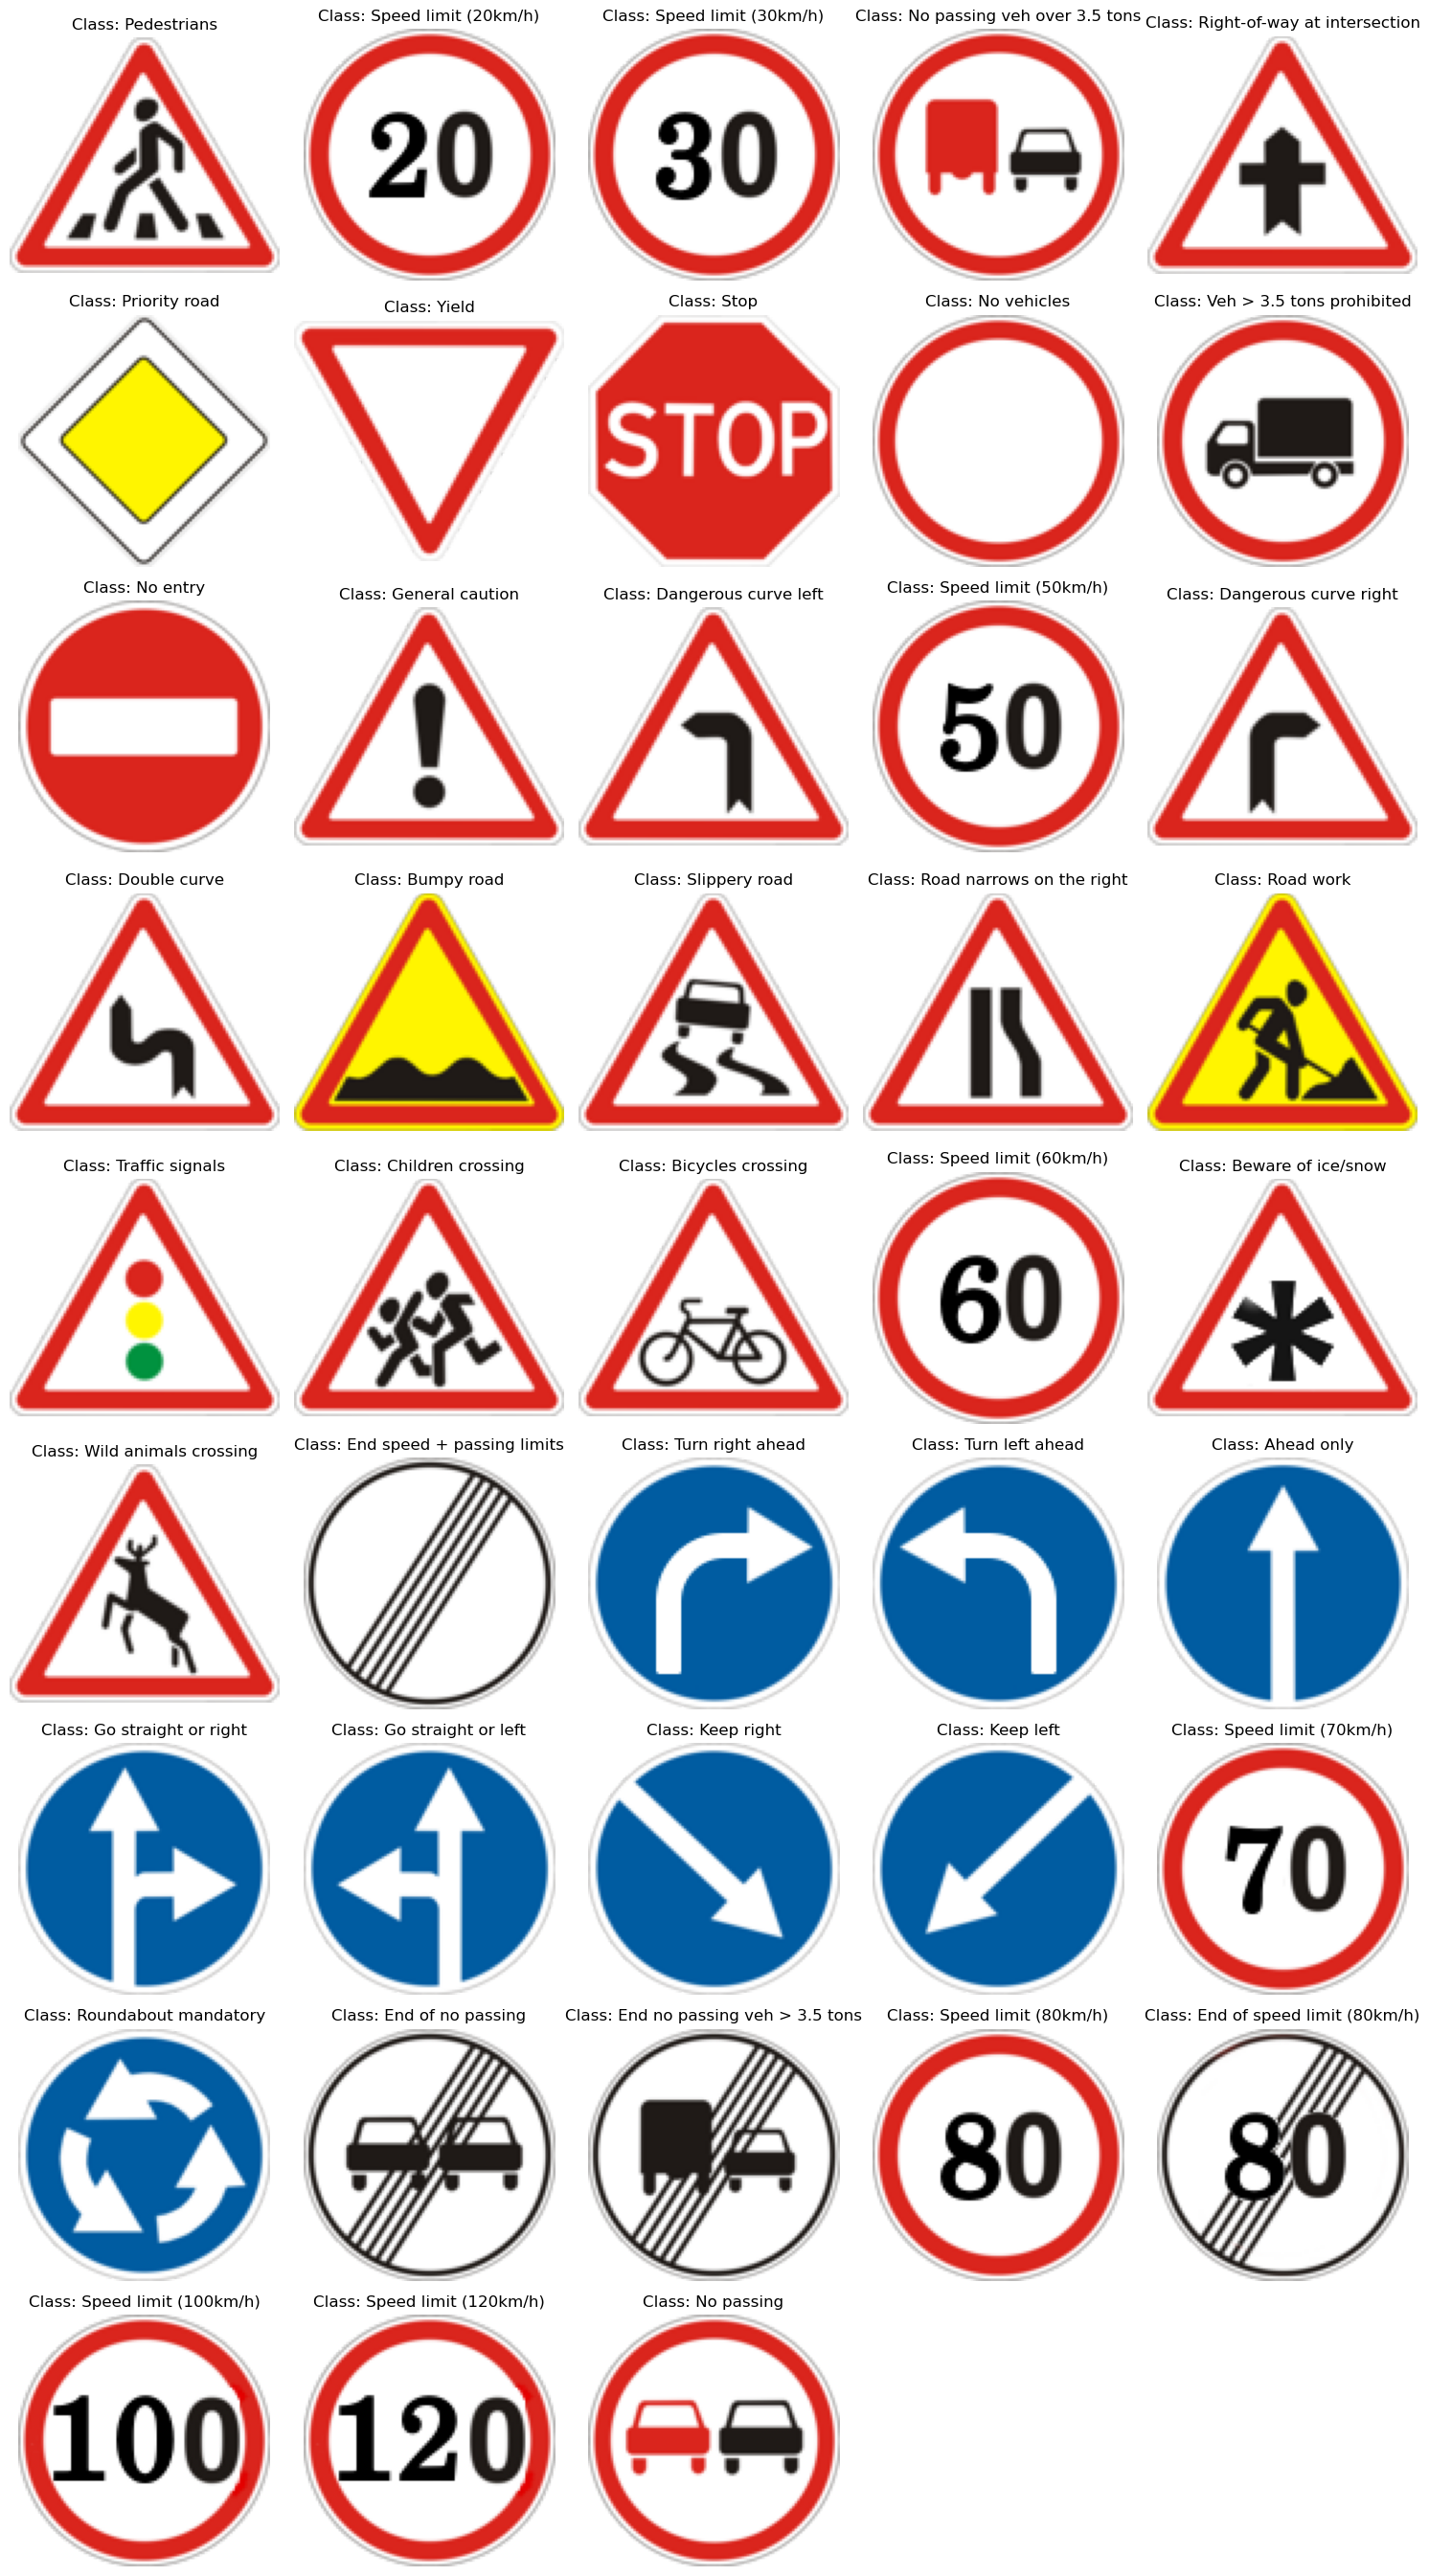

In [62]:
images_per_row = 5
total_images = len(meta_df)
rows = (total_images // images_per_row) + (total_images % images_per_row > 0)

fig, axs = plt.subplots(rows, images_per_row, figsize=(15, rows * 3))
axs = axs.flatten()

for idx, (_, row) in enumerate(meta_df.iterrows()):
    img_path = os.path.join(cur_path, row['Path'])
    class_id = row['ClassId']
    class_name = classes.get(class_id, "Unknown")

    img = Image.open(img_path)

    axs[idx].imshow(img)
    axs[idx].set_title(f"Class: {class_name}")
    axs[idx].axis('off')

for i in range(idx + 1, len(axs)):
    axs[i].axis('off')

plt.tight_layout()
plt.show()


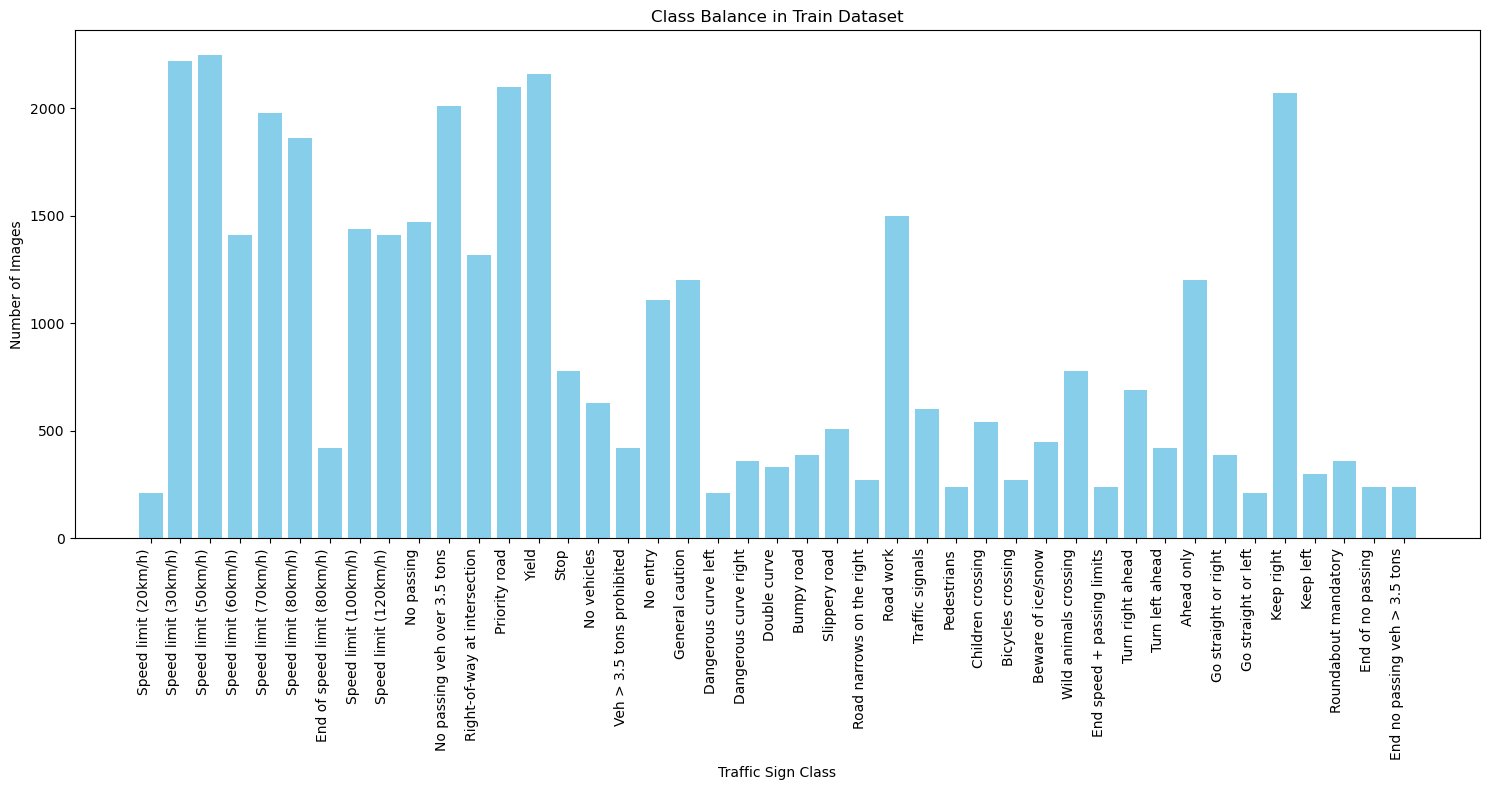

In [63]:
class_counts = train_df['ClassId'].value_counts().sort_index()
class_labels = [classes[i] for i in class_counts.index]

plt.figure(figsize=(15, 8))
plt.bar(class_labels, class_counts, color='skyblue')
plt.xticks(rotation=90, ha='right')
plt.xlabel('Traffic Sign Class')
plt.ylabel('Number of Images')
plt.title('Class Balance in Train Dataset')
plt.tight_layout()
plt.show() #вывод => они не сбалансированы

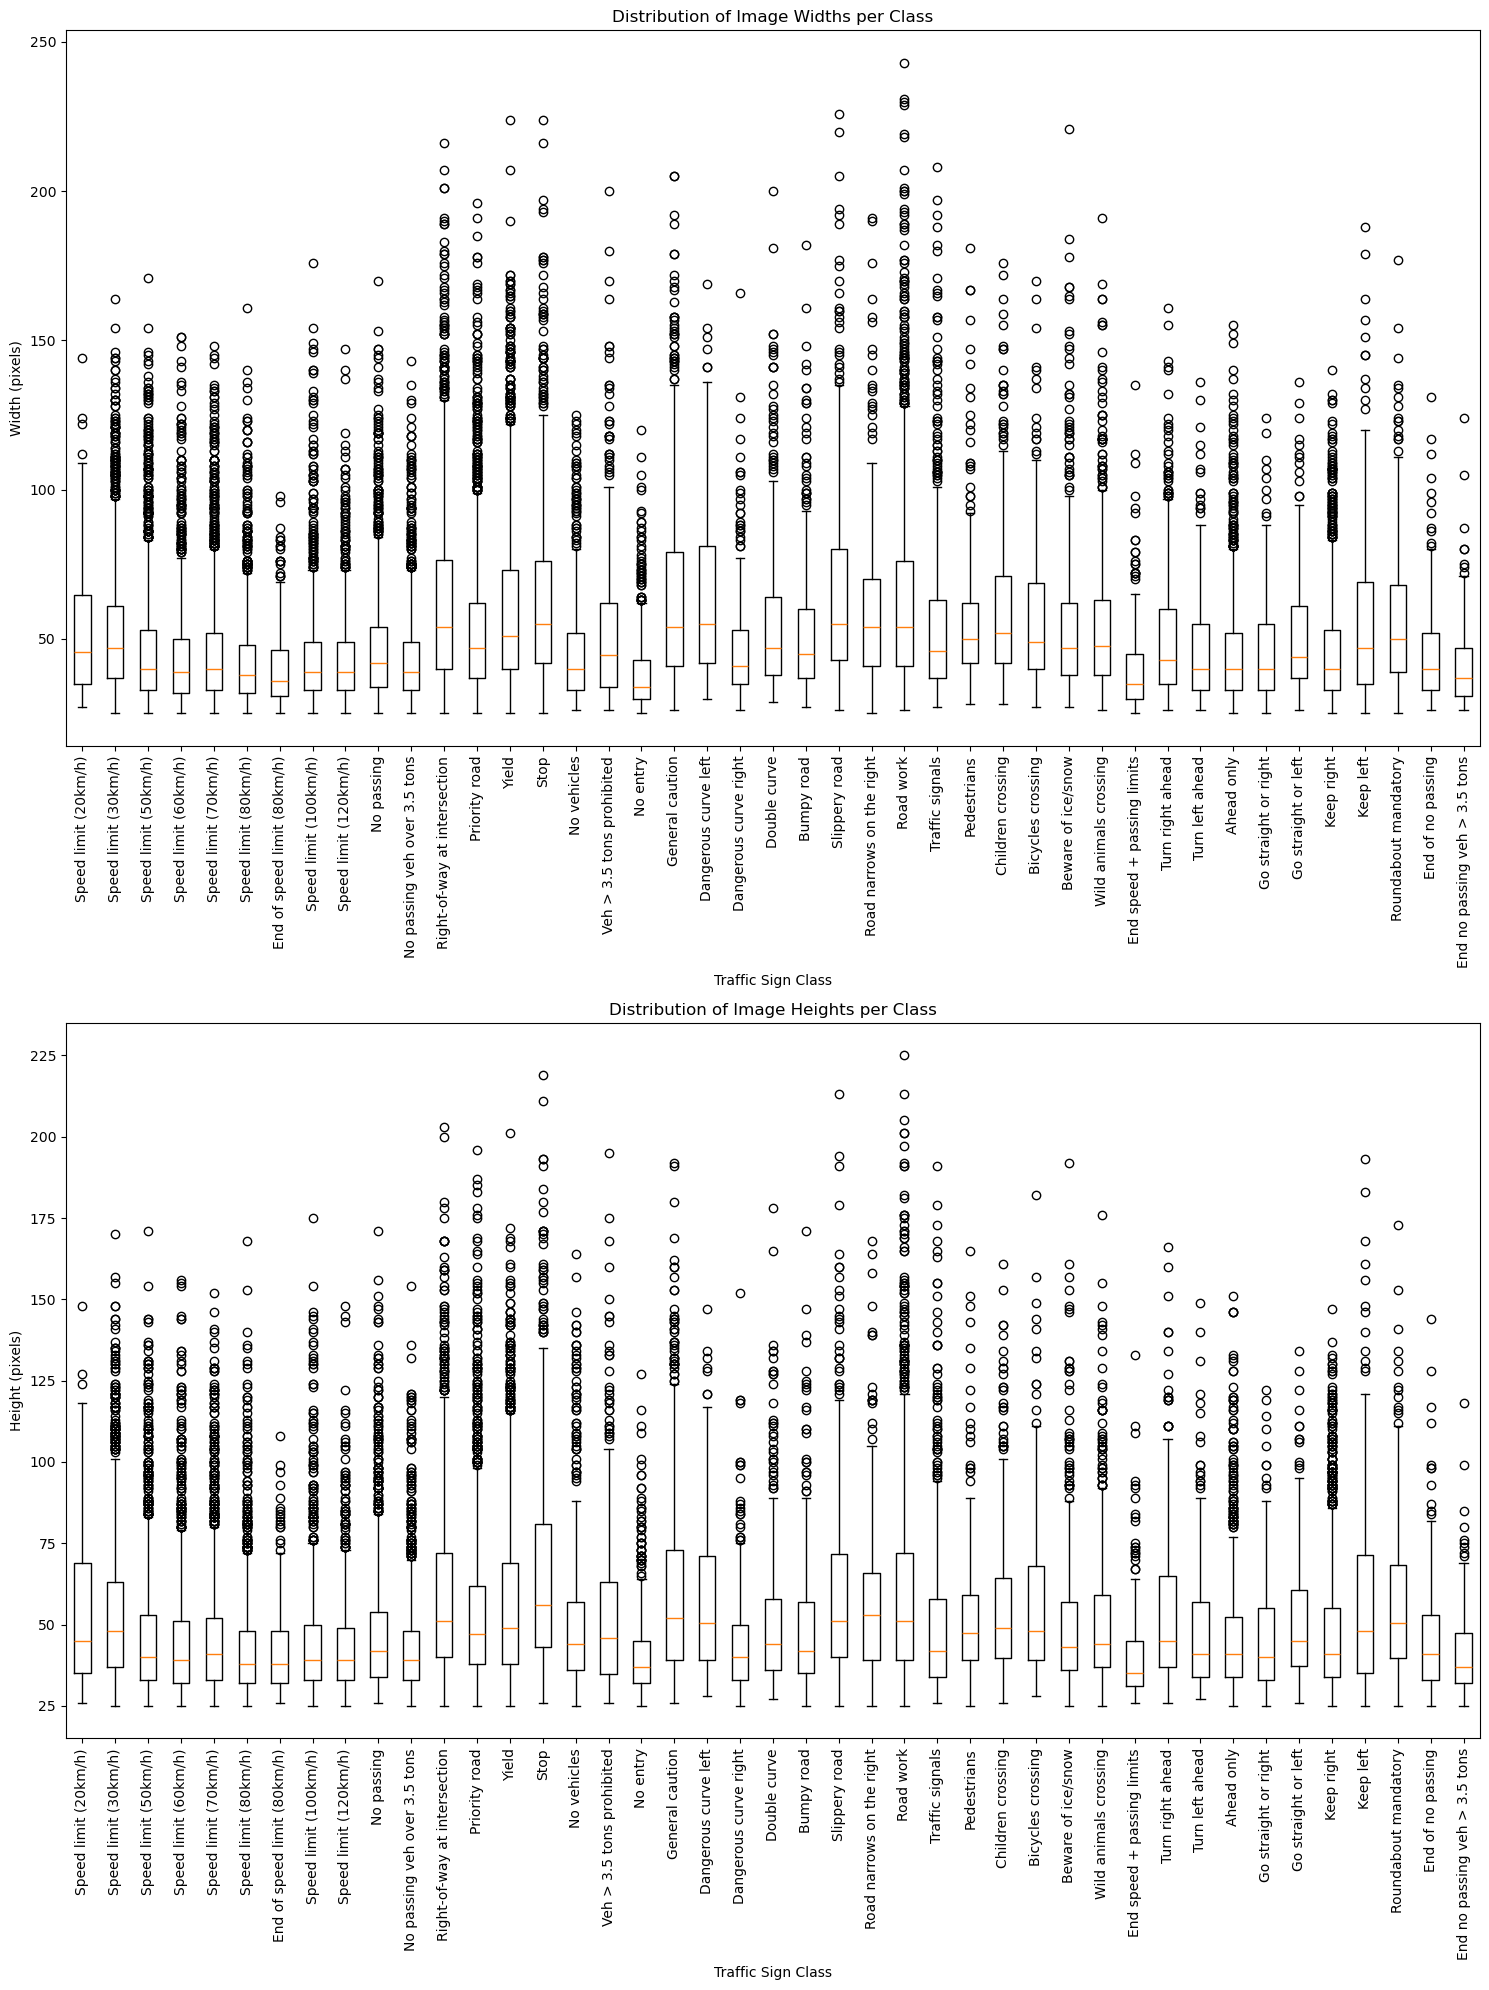

In [64]:
train_df['ClassName'] = train_df['ClassId'].map(classes)

fig, axs = plt.subplots(2, 1, figsize=(15, 20))

axs[0].boxplot([train_df[train_df['ClassId'] == i]['Width'] for i in range(len(classes))], labels=classes.values())
axs[0].set_xlabel('Traffic Sign Class')
axs[0].set_ylabel('Width (pixels)')
axs[0].set_title('Distribution of Image Widths per Class')
axs[0].tick_params(axis='x', rotation=90)

axs[1].boxplot([train_df[train_df['ClassId'] == i]['Height'] for i in range(len(classes))], labels=classes.values())
axs[1].set_xlabel('Traffic Sign Class')
axs[1].set_ylabel('Height (pixels)')
axs[1].set_title('Distribution of Image Heights per Class')
axs[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()    #вывод => они не сбалансированы

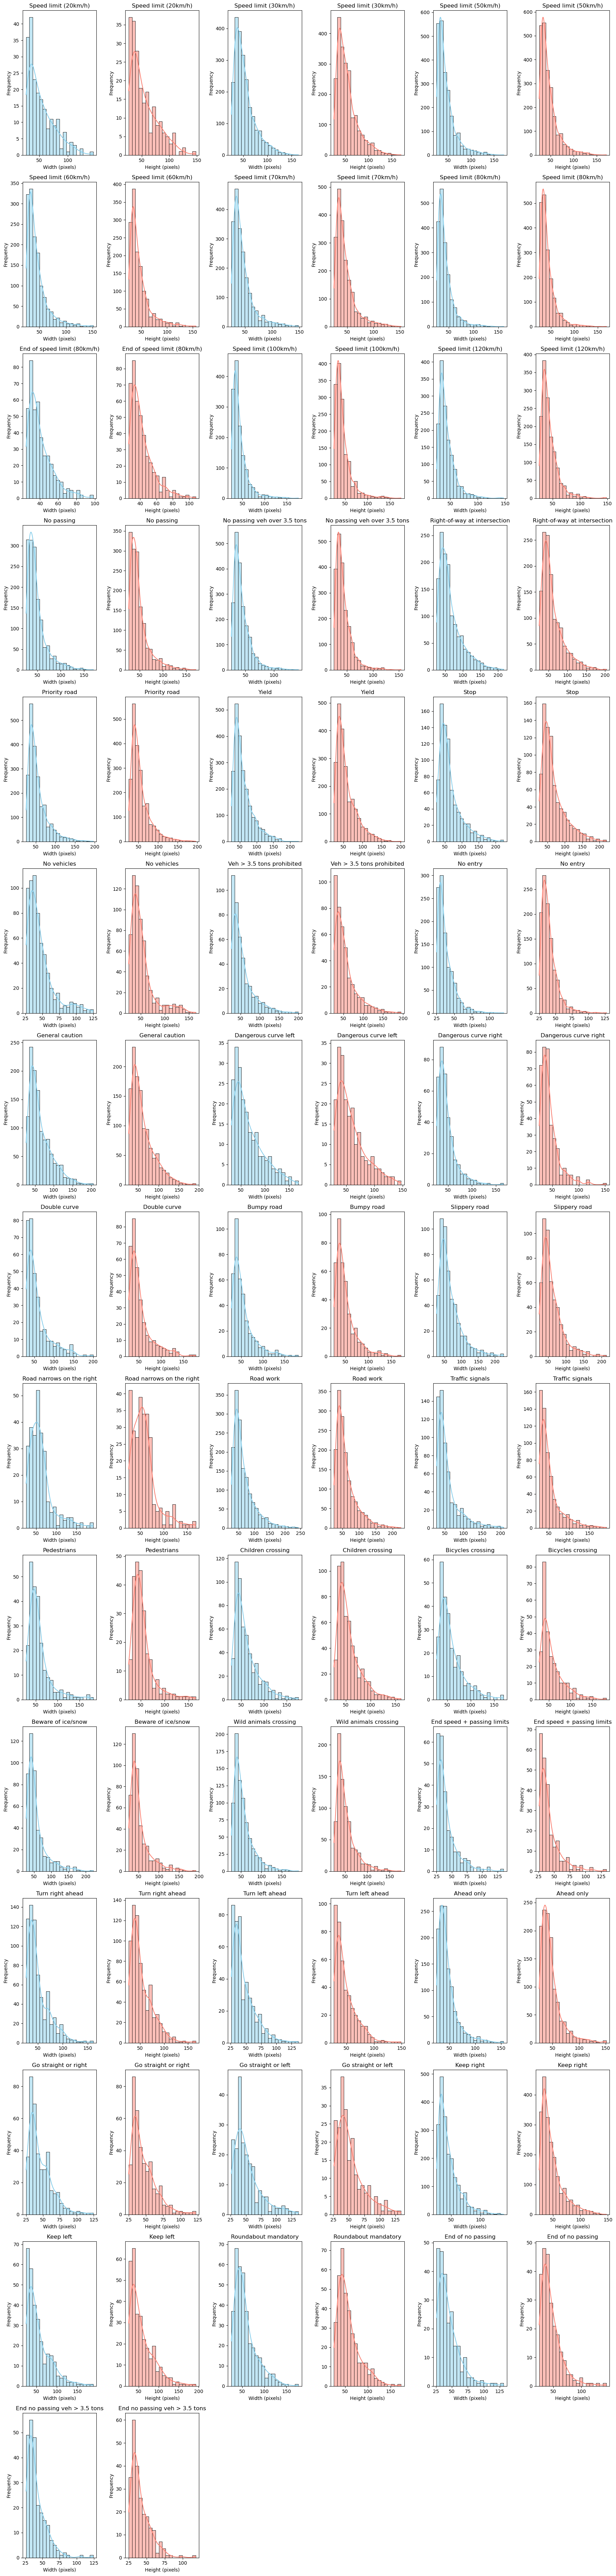

In [65]:
num_classes = len(classes)
num_rows = (num_classes * 2 + 5) // 6 
plt.figure(figsize=(18, num_rows * 5))  

for i, (class_id, class_name) in enumerate(classes.items()):
    plt.subplot(num_rows, 6, 2 * i + 1) 
    sns.histplot(train_df[train_df['ClassId'] == class_id]['Width'], bins=20, kde=True, color="skyblue")
    plt.title(f"{class_name}")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Frequency")
    
    plt.subplot(num_rows, 6, 2 * i + 2)  
    sns.histplot(train_df[train_df['ClassId'] == class_id]['Height'], bins=20, kde=True, color="salmon")
    plt.title(f"{class_name}")
    plt.xlabel("Height (pixels)")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show() #вывод => Все классы имеют одинаковое распределение высоты и ширины, некоторые классы в среднем содержат изображения большего размера

In [100]:
class GTSRBDataset(Dataset):
    def __init__(self, dataframe, root_dir, train=False):
        self.annotations = dataframe
        self.root_dir = root_dir
        
        #нормализация для RGB
        self.normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        
        #АУГМЕНТАЦИЯ
        if train:
            self.transform = transforms.Compose([
                transforms.RandomRotation(10),
                transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.9,1.1)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue = 0.1),
                transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # рандомно делаем crop и resize
                transforms.GaussianBlur(kernel_size=3),
                transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
                #transforms.RandomHorizontalFlip(),
                #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  #рандомно меняем эти параметры
                transforms.ToTensor(),
                transforms.RandomErasing(p=0.5, scale=(0.02,0.1), ratio=(0.3,3.3)),
                self.normalize
            ])
        else:
            # transform для валидации (без аугментации)
            self.transform = transforms.Compose([
                transforms.Resize((128, 128)),
                transforms.ToTensor(),
                self.normalize
            ])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx]['Path'])
        image = Image.open(img_name).convert('RGB')
        label = self.annotations.iloc[idx]['ClassId'] 

        image = self.transform(image)
        return image, label

In [102]:
print(train_df.head())
print(test_df.head())

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path              ClassName  
0  Train/20/00020_00000_00000.png  Dangerous curve right  
1  Train/20/00020_00000_00001.png  Dangerous curve right  
2  Train/20/00020_00000_00002.png  Dangerous curve right  
3  Train/20/00020_00000_00003.png  Dangerous curve right  
4  Train/20/00020_00000_00004.png  Dangerous curve right  
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38

In [104]:
import torchvision.models as models

In [106]:
batch_sizes = [32, 16, 8]
learning_rates = [0.0001, 0.00005, 0.00001]
num_epochs_list = [10, 15, 20]
cost = nn.CrossEntropyLoss()

In [108]:
batch_size = 16
learning_rate = 0.0001
num_epochs = 20
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

In [110]:
train_dataset = GTSRBDataset(train_df, cur_path, train=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = GTSRBDataset(test_df, cur_path)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model = models.alexnet(pretrained=True)

# устанавливаем финальный слой для этого данного в задаче числа классов
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, num_classes)

optimizers = [
    torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4),
    torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
]
total_step = len(train_loader)
history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
for optimizer_ in optimizers:
    optimizer = optimizer_
    print("batch_size=",batch_size,",learning_rate=",learning_rate, ",num_epochs=", num_epochs, ",optimizer=", optimizer)
    for epoch in range(num_epochs):
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        #print(f"Input image shape: {images.shape}")
        #print(f"Input image type: {images.dtype}")
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = cost(outputs, labels)
      
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            #if (i+1) % 600 == 0:
            #    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        average_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {average_loss:.4f}")
        print("-" * 20)
    print("Модель обучена")
    with torch.no_grad():
        correct = 0
        total = 0
        running_val_loss = 0.0
        for i, (images, labels) in enumerate(test_loader):
                #print(images)
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
    
                loss = cost(outputs, labels)
                running_val_loss += loss.item()
            
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_accuracy = 100 * correct / total
        val_loss = running_val_loss / len(test_loader)
        #print('Accuracy of the network on test images: {} %'.format(100 * correct / total))
        print('Validation Accuracy of the network on test images:', val_accuracy, '%')
        print('Validation Loss:', val_loss)

batch_size= 16 ,learning_rate= 0.0001 ,num_epochs= 20 ,optimizer= SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch [1/20]
Epoch [1/20], Average Loss: 1.4379
--------------------
Epoch [2/20]
Epoch [2/20], Average Loss: 0.7147
--------------------
Epoch [3/20]
Epoch [3/20], Average Loss: 0.5142
--------------------
Epoch [4/20]
Epoch [4/20], Average Loss: 0.4085
--------------------
Epoch [5/20]
Epoch [5/20], Average Loss: 0.3372
--------------------
Epoch [6/20]
Epoch [6/20], Average Loss: 0.2953
--------------------
Epoch [7/20]
Epoch [7/20], Average Loss: 0.2653
--------------------
Epoch [8/20]
Epoch [8/20], Average Loss: 0.2422
--------------------
Epoch [9/20]
Epoch [9/20], Average Loss: 0.2241
--------------------
Epoch [10/20]
Epoch [10/20], Average Loss: 0.2040
--------------------
Epoch [11/20]
Epoch [11/20], Average Loss